# Decision Tree Models para el mercado inmobiliario

En el presente notebook investigamos distintos tipos de modelos basados en árboles de decisión para predecir los valores de las propiedades en el mercado inmobiliario de Buenos Aires. Los árboles de decisión y sus ensambles tienen la capacidad de generar buenos ajustes en datasets heterogéneos y complejos como el que trabajamos aquí. La información ha sido extraída de [Properati](https://www.properati.com.ar/data/).

Empezamos por importar librerías, y acomodar el dataset para su posterior modelado.

In [1]:
import os
# import warnings
# warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

In [2]:
os.chdir('..')
df = pd.read_csv('Data/Properati_data_clean.csv')
os.chdir('Notebooks')
df.head()

,created_on,lat,lon,barrio_publicado,rooms,surface_total,surface_covered,price,title,description,property_type,barrio,surface_uncovered,price_m2
0,2019-08-04,-34.601864,-58.443563,Villa Crespo,3.0,67.0,60.0,110000.0,Departamento venta,Warnes al 500 – Villa Crespo – CABA. \r\nAmpli...,Departamento,VILLA CRESPO,7.0,1732.283465
1,2019-08-04,-34.644735,-58.421061,Boedo,2.0,40.0,40.0,79900.0,Departamento - Boedo - 2 amb MUY LUMINOSO!! ...,"GRAN OPORTUNIDAD, SE BAJO DE PRECIO!! IDEAL I...",Departamento,NUEVA POMPEYA,0.0,1997.500000
2,2019-08-04,-34.603423,-58.431140,Almagro,2.0,38.0,38.0,112000.0,Dos Ambientes Reciclado a 1 cuadra del Subte B,"Dos Ambientes Reciclado, primer piso contrafre...",Departamento,ALMAGRO,0.0,2947.368421
3,2019-08-04,-34.609326,-58.492374,Villa del Parque,2.0,94.0,77.0,169000.0,PH DE 3 PLANTAS CON COCHERA PROPIA Y TERRAZA,Hermoso e impecable triplex con vista verde ha...,PH,VILLA DEL PARQUE,17.0,1976.608187
4,2019-05-27,-34.629607,-58.439279,NaN,1.0,41.0,37.0,118000.0,Departamento venta,"Increible departamento 41 m2, mono ambiente en...",Departamento,PARQUE CHACABUCO,4.0,3025.641026


### Feature Engineering

Vamos a eliminar algunas variables que no consideremos relevantes, convertir otras a dummies y agregar algunas cruzando nuestro dataset con información extraída de otras fuentes.

In [3]:
# Dropeamos columnas
df.drop(columns=['created_on','barrio_publicado','title','description','price_m2'],inplace=True)
# Agregamos dummies para property_type (tres tipos, dos dummies)
df['PH'] = np.where((df.property_type == 'PH'),1,0)
df['Casa'] = np.where((df.property_type == 'casa'),1,0)
# Eliminamos esta columna cualitativa
df.drop(columns='property_type',inplace=True)
# Eliminamos los NaNs (están en la columna Rooms) y reseteamos el index
df.dropna(inplace=True)
df.reset_index(inplace=True,drop=True)
# A ver...
df

,lat,lon,rooms,surface_total,surface_covered,price,barrio,surface_uncovered,PH,Casa
0,-34.601864,-58.443563,3.0,67.0,60.0,110000.0,VILLA CRESPO,7.0,0,0
1,-34.644735,-58.421061,2.0,40.0,40.0,79900.0,NUEVA POMPEYA,0.0,0,0
2,-34.603423,-58.431140,2.0,38.0,38.0,112000.0,ALMAGRO,0.0,0,0
3,-34.609326,-58.492374,2.0,94.0,77.0,169000.0,VILLA DEL PARQUE,17.0,1,0
4,-34.629607,-58.439279,1.0,41.0,37.0,118000.0,PARQUE CHACABUCO,4.0,0,0
...,...,...,...,...,...,...,...,...,...,...
25505,-34.580718,-58.440610,4.0,82.0,77.0,250000.0,PALERMO,5.0,0,0
25506,-34.578688,-58.435533,2.0,80.0,80.0,170000.0,PALERMO,0.0,0,0
25507,-34.581425,-58.442707,3.0,88.0,82.0,399000.0,PALERMO,6.0,0,0
25508,-34.576573,-58.434394,3.0,84.0,84.0,178000.0,PALERMO,0.0,1,0


A continuación vamos a agregar algunos features que podrían ser relevantes para determinar el valor de una propiedad, y que, cuando están disponibles, suelen utilizarse en modelos predictivos del precio. Se trata de la densidad poblacional y el ingreso pér capita. En el caso de la Ciudad de Buenos Aires, dicha información es publicada por comuna, por la [Dirección de Estadística y Censos](https://www.estadisticaciudad.gob.ar/eyc/). Para poder aplicarla a nuestro dataset, vamos a utilizar adicionalmente el mapeo de barrios a comunas publicado en [BA Data](https://data.buenosaires.gob.ar/dataset/barrios).

In [4]:
os.chdir('..')
df_comunas = pd.read_csv('Data/barrios_comunas.csv')
df_densidad = pd.read_csv('Data/densidad_poblacional_por_comuna_CABA_2018.csv')
df_ingreso = pd.read_csv('Data/ingreso_per_cap_2018_por_comuna_CABA.csv')
os.chdir('Notebooks')
df_comunas.head()

,BARRIO,COMUNA
0,AGRONOMIA,15
1,ALMAGRO,5
2,BALVANERA,3
3,BARRACAS,4
4,BELGRANO,13


In [5]:
# Creamos función que asigna comunas a barrios
def comuna(barrio):
    for j in range(len(df_comunas)):
        comuna = 0
        if df_comunas.at[j,'BARRIO'] == barrio:
            comuna = df_comunas.at[j,'COMUNA']
            break
    return comuna

In [6]:
# Asignamos comuna al df con la función así definida
df['comuna'] = 0
for i in range(len(df)):
    df.at[i,'comuna'] = comuna(df.at[i,'barrio'])

Ahora sí agregamos ingreso pér cápita y densidad poblacional a cada propiedad, en función de su comuna. Nótese que como éstas dos variables no están perfectamente correlacionadas, puede servirnos agregar las dos a pesar de que dividan el dataset en las mismas comunas.

In [7]:
df_ingreso.head()

,comuna,ingreso
0,1,22162
1,2,31249
2,3,19692
3,4,14176
4,5,22502


In [8]:
# Función para asignar valor según comuna, nos servirá para ingreso y densidad

def valor(df,comuna,rubro):
    valor = 0
    for i in range(len(df)):
        if df.at[i,'comuna'] == comuna:
            valor = df.at[i,rubro]
    return valor

In [9]:
# Asignamos ingreso y densidad al df con esta función
df['ingres_pcap'] = 0
df['densidad'] = 0
for i in range(len(df)):
    df.at[i,'ingres_pcap'] = valor(df_ingreso,df.at[i,'comuna'],'ingreso')
    df.at[i,'densidad'] = valor(df_densidad,df.at[i,'comuna'],'densidad')

In [10]:
# Eliminamos el feature categórico "barrio"
df.drop(columns='barrio',inplace=True)
# A ver como quedo
df

,lat,lon,rooms,surface_total,surface_covered,price,surface_uncovered,PH,Casa,comuna,ingres_pcap,densidad
0,-34.601864,-58.443563,3.0,67.0,60.0,110000.0,7.0,0,0,15,20204,12737
1,-34.644735,-58.421061,2.0,40.0,40.0,79900.0,0.0,0,0,4,14176,11042
2,-34.603423,-58.431140,2.0,38.0,38.0,112000.0,0.0,0,0,5,22502,28106
3,-34.609326,-58.492374,2.0,94.0,77.0,169000.0,17.0,1,0,11,20827,13458
4,-34.629607,-58.439279,1.0,41.0,37.0,118000.0,4.0,0,0,7,17272,19398
...,...,...,...,...,...,...,...,...,...,...,...,...
25505,-34.580718,-58.440610,4.0,82.0,77.0,250000.0,5.0,0,0,14,34357,14325
25506,-34.578688,-58.435533,2.0,80.0,80.0,170000.0,0.0,0,0,14,34357,14325
25507,-34.581425,-58.442707,3.0,88.0,82.0,399000.0,6.0,0,0,14,34357,14325
25508,-34.576573,-58.434394,3.0,84.0,84.0,178000.0,0.0,1,0,14,34357,14325


### Train/Test Split

In [11]:
from sklearn.model_selection import train_test_split

# Shuffleamos
np.random.seed(seed=49)
df_perm = np.random.permutation(df)
df = pd.DataFrame(df_perm,columns=df.columns)

# Dividimos en tres conjuntos: train, validation, test
df_train, df_2 = train_test_split(df,test_size=0.3,random_state=50)
df_validation, df_test = train_test_split(df_2,test_size=0.5,random_state=51)

In [64]:
# Tomaremos como target la variable precio, y como input todo lo demás
# Empezaremos por utilizar el dataset sin los features agregados
X_train1 = df_train.drop(columns=['price','comuna','ingres_pcap','densidad'])
X_test1 = df_test.drop(columns=['price','comuna','ingres_pcap','densidad'])
y_train = df_train['price']
y_validation = df_validation['price'] 
y_test = df_test['price']

### Decision Tree

Empezamos por utilizar la versión más elemental de esta familia de modelos: el árbol de decisión. Es probable que no constituya nuestro modelo demasiado bueno, pero servirá de benchmark para ir mejorando nuestras predicciones. Comenzaremos con los parámetros default de sci-kit learn.

In [68]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,r2_score

tree1 = DecisionTreeRegressor(random_state=52)
tree1.fit(X_train1,y_train)
y_pred1 = tree1.predict(X_test1)
rmse1 = np.sqrt(mean_squared_error(y_test,y_pred1))
r2_tree1 = r2_score(y_test,y_pred1)
print(f"RMSE: {rmse1}")
print(f"R2: {r2_tree1}")

RMSE: 40346.81103132974
R2: 0.758761513624177


### Decision Tree: feature engineering

Veamos ahora si el agregado de variables realizado en la sección de feature engineering logra aportar mayor valor.

In [66]:
# Conjuntos de features con todos los features
X_train = df_train.drop(columns=['price'])
X_validation = df_validation.drop(columns=['price'])
X_test = df_test.drop(columns=['price'])

In [88]:
tree2 = DecisionTreeRegressor(random_state=52)
tree2.fit(X_train,y_train)
y_pred2 = tree2.predict(X_test)
rmse2 = np.sqrt(mean_squared_error(y_test,y_pred2))
r2_tree2 = r2_score(y_test,y_pred2)
print(f"RMSE: {rmse2}")
print(f'Mejora RMSE benchmark: %.2f'% (((rmse1 - rmse2)/rmse1)*100)+'%')
print(f"R2: {r2_tree2}")

RMSE: 39961.6753431997
Mejora RMSE benchmark: 0.95%
R2: 0.7633450783740112


La performance es apenas mejor. Para compararlos con más entendimiento, y mejorar la performance de ambos, vamos a hacer un Grid Search sobre los parámetros.

### Decision Tree: optimización de hiperparámetros

In [17]:
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate

# Parámetros a considerar: criterion, splitter, max_depth (regularizador)
param_grid1 = {'splitter':['best','random'],'max_depth':[10,50,100],\
              'max_features':[4,6,len(X_train1.columns)],}
param_grid2 = {'splitter':['best','random'],'max_depth':[10,50,100],\
              'max_features':[4,8,len(X_train.columns)],}

grid_tree1 = GridSearchCV(tree1,param_grid1,scoring='neg_mean_squared_error',cv=5)
grid_tree2 = GridSearchCV(tree2,param_grid2,scoring='neg_mean_squared_error',cv=5)
grid_tree1.fit(X_train1,y_train)
grid_tree2.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=52,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [10, 50, 100], 'max_features': [4, 8, 11],
                         'splitter': ['best', 'random']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,

In [43]:
# Creamos un dataframe con los resultados
df_scores1 = pd.DataFrame(grid_tree1.cv_results_)
# Lo tuneamos un poquito
df_scores1 = df_scores1[['mean_test_score','rank_test_score','param_splitter','param_max_depth','param_max_features']]
df_scores1['rmse'] = np.sqrt(-df_scores1['mean_test_score'])
df_scores1 = df_scores1.sort_values('rank_test_score').head(7)
# A ver...
df_scores1

,mean_test_score,rank_test_score,param_splitter,param_max_depth,param_max_features,rmse
4,-1.405689e+09,1,best,10,8,37492.514919
2,-1.416733e+09,2,best,10,6,37639.511700
0,-1.452160e+09,3,best,10,4,38107.212695
5,-1.536601e+09,4,random,10,8,39199.496400
14,-1.669071e+09,5,best,100,6,40854.262948
8,-1.669071e+09,5,best,50,6,40854.262948
16,-1.686136e+09,7,best,100,8,41062.590729


In [44]:
df_scores2 = pd.DataFrame(grid_tree2.cv_results_)
df_scores2 = df_scores2[['mean_test_score','rank_test_score','param_splitter','param_max_depth','param_max_features']]
df_scores2['rmse'] = np.sqrt(-df_scores2['mean_test_score'])
df_scores2 = df_scores2.sort_values('rank_test_score').head(7)
df_scores2

,mean_test_score,rank_test_score,param_splitter,param_max_depth,param_max_features,rmse
2,-1.386071e+09,1,best,10,8,37229.979523
4,-1.387617e+09,2,best,10,11,37250.729091
0,-1.401472e+09,3,best,10,4,37436.237517
5,-1.454579e+09,4,random,10,11,38138.942383
3,-1.469161e+09,5,random,10,8,38329.632833
1,-1.595502e+09,6,random,10,4,39943.738055
14,-1.602720e+09,7,best,100,8,40033.984011


Efectivamente, el modelo con más features tiene un rendimiento (levemente) superior. Gráficamente:

Text(0.5, 1.0, 'RMSE for Decision Tree Models')

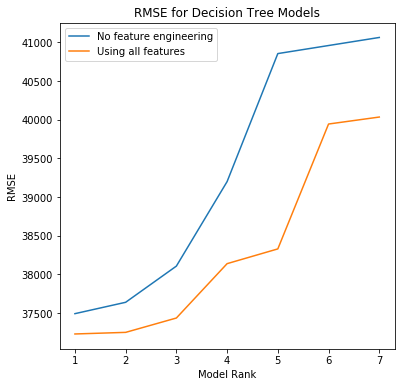

In [45]:
plt.figure(figsize=(6,6))
plt.plot(df_scores1.rank_test_score,df_scores1.rmse,label='No feature engineering')
plt.plot(df_scores2.rank_test_score,df_scores2.rmse,label='Using all features')
plt.legend()
plt.xlabel('Model Rank')
plt.ylabel('RMSE')
plt.title('RMSE for Decision Tree Models')

De modo que vamos a utilizar todos nuestros features, incluidos los que agregamos en el apartado de feature engineering. Vamos entonces a hilar más fino en el tuning de los hiperparámetros. El "splitter" lo dejaremos en best, pero veamos qué sucede con max_features (alrededor del 10) y max_depth (entre 8 y 11).

In [49]:
param_grid3 = {'max_depth':[6,8,9,10,11,12,15,20],'max_features':[8,9,10,11],}

grid_tree3 = GridSearchCV(tree2,param_grid3,scoring='neg_mean_squared_error',cv=5)
grid_tree3.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=52,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [6, 8, 9, 10, 11, 12, 15, 20],
                         'max_features': [8, 9, 10, 11]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
           

In [50]:
df_scores3 = pd.DataFrame(grid_tree3.cv_results_)
df_scores3 = df_scores3[['mean_test_score','rank_test_score','param_max_depth','param_max_features']]
df_scores3['rmse'] = np.sqrt(-df_scores3['mean_test_score'])
df_scores3 = df_scores3.sort_values('rank_test_score')
df_scores3.head(7)

,mean_test_score,rank_test_score,param_max_depth,param_max_features,rmse
9,-1.376204e+09,1,9,9,37097.226174
10,-1.377331e+09,2,9,10,37112.415469
5,-1.381018e+09,3,8,9,37162.055721
11,-1.382920e+09,4,9,11,37187.632645
7,-1.384999e+09,5,8,11,37215.580502
4,-1.385484e+09,6,8,8,37222.083607
12,-1.386071e+09,7,10,8,37229.979523


Gráficamente:

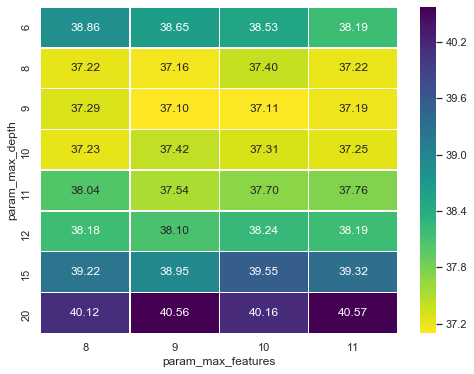

In [180]:
sns.set()
df_heat = df_scores3.groupby(['param_max_depth','param_max_features'])
df_heat = df_heat['rmse'].sum().unstack()
# Lo paso a miles
df_heat = round((df_heat / 1000),4)
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df_heat, annot=True, fmt='.2f', linewidths=.5, cmap='viridis_r', ax=ax)

Tenemos un ganador, veamos su performance.

In [87]:
y_pred3 = grid_tree3.predict(X_test)
rmse3 = np.sqrt(mean_squared_error(y_test,y_pred3))
r2_tree3 = r2_score(y_test,y_pred2)
print(f"RMSE: {rmse3}")
print('Mejora RMSE benchmark: %.2f'% (((rmse1 - rmse3)/rmse1)*100)+'%')
print(f"R2: {r2_tree3}")

RMSE: 37168.42358734967
Mejora RMSE benchmark: 7.88%
R2: 0.7633450783740112


### Random Forest Regressor

A continuación entrenamos un modelo más poderoso, Random Forest. El procedimiento será similar al apartado anterior.

In [86]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=52)
rfr.fit(X_train,y_train)
y_train_pred4 = rfr.predict(X_train)
y_test_pred4 = rfr.predict(X_test)
rmse_train4 = np.sqrt(mean_squared_error(y_train,y_train_pred4))
rmse_test4 = np.sqrt(mean_squared_error(y_test,y_test_pred4))
print(f'RMSE train: {rmse_train}')
print(f'RMSE test: {rmse_test}')
print('Mejora benchmark: %.2f'% (((rmse1 - rmse_test4)/rmse1)*100)+' %')

C:\Users\Usuario\Python\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE train: 13004.557949541839
RMSE test: 30317.418855065273
Mejora benchmark: 23.30 %


Pese a la sustancial mejora respecto de nuestro benchmark, tenemos un enorme grado de overfitting. A continuación haremos Grid Search con cross validation para atacar este problema.

In [91]:
forest_grid = {'n_estimators':[30,50,70,100,120,150],'max_depth':[None,5,10,20,30,50]}
# cv=2 por el tiempo de espera, luego se puede ajustar
rnr_grid = GridSearchCV(rfr,forest_grid,cv=2,scoring='neg_mean_squared_error',return_train_score=True).fit(X_train,y_train)

In [223]:
rnrgrid_df1 = pd.DataFrame(rnr_grid.cv_results_)
rnrgrid_df1 = rnrgrid_df1[['param_max_depth','param_n_estimators',\
                    'mean_test_score','rank_test_score','mean_fit_time']]
rnrgrid_df1 = rnrgrid_df1
rnrgrid_df1['rmse_test'] = np.sqrt(-rnrgrid_df1['mean_test_score'])
# Veamos una muestra
rnrgrid_df1.sort_values(by='rank_test_score').head(7)

,param_max_depth,param_n_estimators,mean_test_score,rank_test_score,mean_fit_time,rmse_test
29,30,150,-1.039669e+09,1,5.779660,32243.893615
5,None,150,-1.040213e+09,2,5.559671,32252.332725
35,50,150,-1.040213e+09,2,5.548254,32252.332725
28,30,120,-1.041319e+09,4,4.362354,32269.475335
4,None,120,-1.041802e+09,5,4.818660,32276.961120
34,50,120,-1.041802e+09,5,4.744757,32276.961120
27,30,100,-1.042522e+09,7,3.894858,32288.114231


Gráficamente:

In [227]:
# Convierto los None a string para que pandas los tabule
rnrgrid_df1.fillna('None',inplace=True)
# Creo una tabla tipo pivot con mis parámetros
table = rnrgrid_df1.groupby(['param_max_depth','param_n_estimators'])['rmse_test'].sum().unstack()
table = round(table/1000,2)

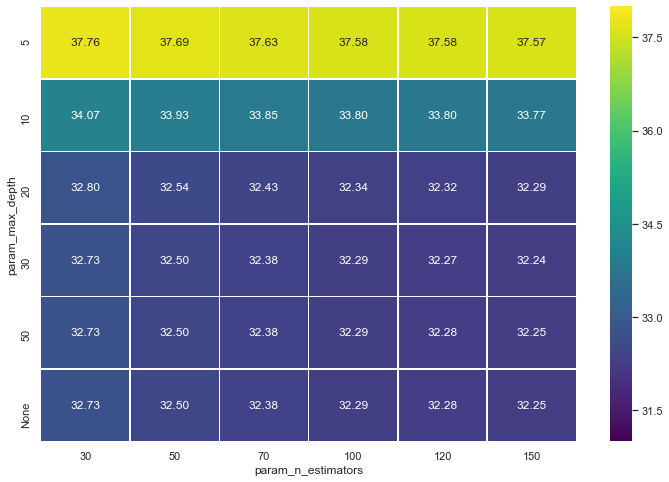

In [228]:
# Grid Search Heatmap
sns.set()
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(table, annot=True, fmt='.2f',linewidths=.5, cmap='viridis', ax=ax, vmin=31, vmax=38)

El RMSE disminuye a medida que nos movemos hacia abajo (mayor max_depth) y hacia la derecha (mayor n_estimators). A partir de una profunidad de 20 o 30 la ganancia es cada vez más reducida. A continuación haremos un Grid Search con más parámetros.

In [229]:
forest_grid2 = {'max_depth':[30,50],'max_features':[5,8,11],'n_estimators':[150],'min_samples_split':[2,5,10,20,50]}
rnr_grid2 = GridSearchCV(rfr,forest_grid2,cv=2,scoring='neg_mean_squared_error',return_train_score=True).fit(X_train,y_train)

In [241]:
rnrgrid_df2 = pd.DataFrame(rnr_grid2.cv_results_)
rnrgrid_df2 = rnrgrid_df2[['param_max_depth','param_n_estimators',\
                'param_min_samples_split', 'param_max_features',\
                    'mean_test_score','rank_test_score','mean_fit_time']]
rnrgrid_df2['rmse_test'] = np.sqrt(-rnrgrid_df2['mean_test_score'])
rnrgrid_df2 = rnrgrid_df2.drop(columns=['mean_test_score'])
# Veamos una muestra
rnrgrid_df2.sort_values(by='rank_test_score').head(7)

,param_max_depth,param_n_estimators,param_min_samples_split,param_max_features,rank_test_score,mean_fit_time,rmse_test
5,30,150,2,8,1,4.234339,32094.950195
20,50,150,2,8,2,4.498986,32103.882661
15,50,150,2,5,3,3.089316,32108.988656
0,30,150,2,5,4,3.118141,32121.521233
10,30,150,2,11,5,6.088236,32243.893615
25,50,150,2,11,6,5.656644,32252.332725
21,50,150,5,8,7,3.785478,32302.360095


In [242]:
# Hilando un poco más fino
forest_grid3 = {'max_depth':[30,40,50],'max_features':[7,8,9],'n_estimators':[150,200,300],'min_samples_split':[2]}
rnr_grid3 = GridSearchCV(rfr,forest_grid3,cv=2,scoring='neg_mean_squared_error',return_train_score=True).fit(X_train,y_train)

In [243]:
rnrgrid_df3 = pd.DataFrame(rnr_grid3.cv_results_)
rnrgrid_df3 = rnrgrid_df3[['param_max_depth','param_n_estimators',\
                'param_min_samples_split', 'param_max_features',\
                    'mean_test_score','rank_test_score','mean_fit_time']]
rnrgrid_df3['rmse_test'] = np.sqrt(-rnrgrid_df3['mean_test_score'])
rnrgrid_df3 = rnrgrid_df3.drop(columns=['mean_test_score'])
# Veamos una muestra
rnrgrid_df3.sort_values(by='rank_test_score').head(7)

,param_max_depth,param_n_estimators,param_min_samples_split,param_max_features,rank_test_score,mean_fit_time,rmse_test
4,30,200,2,8,1,6.182678,32046.770944
5,30,300,2,8,2,9.159861,32053.964193
13,40,200,2,8,3,6.148448,32054.492834
22,50,200,2,8,3,6.679379,32054.492834
23,50,300,2,8,5,10.436625,32056.572152
14,40,300,2,8,5,9.306728,32056.572152
2,30,300,2,7,7,8.103129,32063.353422


Como vemos, las ganancias son cada vez más exiguas. Nos quedaremos entonces con los parámetros óptimos del último Grid Search.

In [246]:
rnr_grid3.best_params_

{'max_depth': 30,
 'max_features': 8,
 'min_samples_split': 2,
 'n_estimators': 200}

Podría estimarse el modelo directamente desde el Grid Search fiteado, pero para calcular luego la feature importance necesito una instancia del Random Forest Regressor.

In [247]:
rfr_opt = RandomForestRegressor(max_depth=30,max_features=8,
                                 min_samples_split=2,n_estimators=200)
rfr_opt.fit(X_train,y_train)
y_pred_rf = rfr_opt.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test,y_pred_rf))
print(f'RMSE test (Random Forest óptimo): {rmse_rf}')
print('Mejora benchmark: %.2f'% (((rmse1 - rmse_rf)/rmse1)*100)+' %')

RMSE test (Random Forest óptimo): 28953.50808244486
Mejora benchmark: 28.24 %


Una gran ventaja del modelo Random Forest (y de los modelos de árboles de decisión en general) es que tienen un alto grado de interpretabilidad. En particular, poseen una métrica, <b>feature importance</b>, que nos permite entender cuáles son los features que más importancia tienen en la regresión. A continuación la estudiaremos.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], <a list of 11 Text xticklabel objects>)

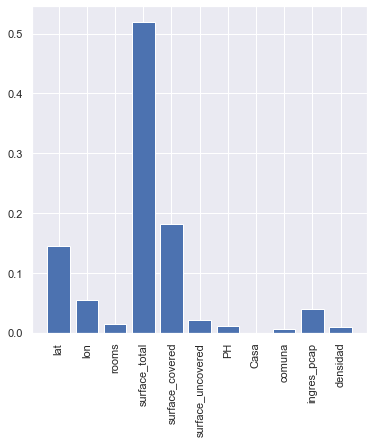

In [274]:
importance = rfr_opt.feature_importances_
Xcolumns = X_train.columns
plt.figure(figsize=(6,6))
plt.bar(Xcolumns,importance)
plt.xticks(rotation=90)

De aquí surgen algunas observaciones interesantes: en primer lugar, y como es esperable, las variables más importantes son las de superficie; por lejos la superficie total es el factor que más explica el precio de una propiedad. En segundo lugar, se nota la asimetría de las coordenadas geográficas: las latitudes son más importantes que las longitudes. Esto no es otra cosa que el reflejo de una conocida característica del mercado inmobiliario porteño: las diferencias más grandes están entre el Norte y el Sur de la Ciudad (las latitudes se mueven "verticalmente" en un mapa, mientras que las longitudes lo hacen de manera "horizontal"). Otra cuestión que surge es el hecho de que, de los features que agregamos de otras bases de datos, el ingreso per cápita de la comuna es una variable más relevante que la densidad poblacional a la hora de explicar el precio de una propiedad. Por último, curiosamente, el feature menos relevante entre los que consideramos es el tipo de propiedad.